# Coding Attention Mechanisms 

### The Problem with Modeling Long Sequences 

Let's go through some pre-Large Language Model (LLM) architectures which do not include attention mechanisms. Suppose we wanted to build a language translation model with an encoder-decoder structure, which is very common in deep neural networks. 

The encoder reads the entire text and understands it, while the decoder produces the translated text. Before the transformer era, there were [RNN](03-sequence-modeling/01-rnn/rnn.ipynb) based encoder and decoder architectures. These architectures performed well on small translation tasks but suffered from long contextual dependencies. Whenever the length of sentences increased, they would lose context. As a result, they could translate text into gibberish language.

**WHY?** Because they were unable to access the hidden state of the previous cell and could only generate text based on the current state. Long Short-Term Memory (LSTM) networks handled this to some extent with a horizontal context line that carries context from one block to the next.

The working of RNNs can be defined as follows: they take the complete input into a hidden state, and the decoder takes this hidden state to produce translated text. (The hidden state is like an understanding of text in numerical form, similar to an embedding.)

### Capturing Data Dependencies with Attention Mechanisms

RNNs needed to remember the entire sentence in a single go (in the hidden state). To overcome this limitation, researchers developed the Bahdanau attention mechanism for RNNs, which modifies the encoder-decoder RNN. This modification allows the decoder to selectively access different parts of the input sequence at each decoding step. As a result, it gains context from both previous and past texts.

### Attending to Different Parts of the Input with Self-Attention

The "self" in self-attention refers to relating a single input sequence to all other parts of the sentence to get the overall input context. This differs from traditional attention mechanisms, which focus on relationships between elements of two different sequences, such as in sequence-to-sequence models where attention might be between an input and an output sequence.

> **A Simple Self-Attention Mechanism without Trainable Weights**

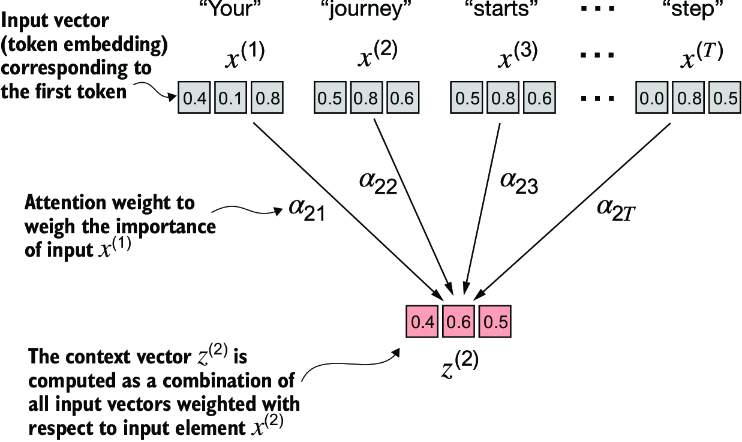

Consider the sentence: "Your journey starts with one step." We divide it into tokens like x1, x2, x3, and so on. Each vector is a three-dimensional embedding. Let's consider the second embedding vector, x2. When we apply self-attention, it becomes z2, which combines information from all other vectors like x1, x3, and x4.

In [23]:
import torch 
from torch import nn
import matplotlib.pyplot as plt 
import numpy as np 

In [24]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [25]:
torch.empty(inputs.shape[0]) # why we use the input.shape[0] cause we wanted the same size of [with 0]


tensor([0., 0., 0., 0., 0., 0.])

In [26]:
query = inputs[1] # x2 
attention_score_x2 = torch.empty(inputs.shape[0]) # creating an empty array 

for i,n in enumerate(inputs):
    
     # x2 will get mul to eveery other tokens 
     # n willl go through all the val in inputs and it will get mul to query that is x2 
     # for example each element in [0.43, 0.15, 0.89] will get mul to each element in elementwise [0.55, 0.87, 0.66]
     # this will genrate new array then we take the sum of array this will gen our first elment in "attention_score_x2" 
    attention_score_x2[i] = torch.dot(n, query)
                                
    
print(attention_score_x2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


#### UNDERSTANDING DOT PRODUCTS

A dot product is essentially a concise way of multiplying two vectors element-wise and then summing the products

> the dot product is a measure of similarity because it quantifies how closely two vectors are aligned: a higher dot product indicates a greater degree of alignment or similarity between the vectors.

In [27]:
res = 0 

for i in range(len(inputs[0])):
    
    res += inputs[0][i] * query[i]
    
print(res)
print(torch.dot(inputs[0],query))

tensor(0.9544)
tensor(0.9544)


In next step we gonna normalise each of the attention score so that the sum all these become ONE but WHY -> if we want stable trianing of LLM then the data should be properly distribuited so it become easy to backprop. 

> We Generally use softmax for this but here we are doing manually just to understanad it.
> Why softmax cause it is better at managing extreme values and offers more favorable gradient properties during training.

In [28]:
attention_score_x2_tmp = attention_score_x2 / attention_score_x2.sum()

print(attention_score_x2_tmp) 
print(attention_score_x2_tmp.sum())

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
tensor(1.0000)


In [29]:
def softmax_tmp(x):
    
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attention_score_x2_softmax = softmax_tmp(attention_score_x2)

print(attention_score_x2_softmax)
print(attention_score_x2_softmax.sum())

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
tensor(1.)


> In addition, the softmax function ensures that the attention weights are always positive. This makes the output interpretable as probabilities or relative importance, where higher weights indicate greater importance.

In [30]:
attn_score_softmax = torch.softmax(attention_score_x2,dim=0)
print(attn_score_softmax)
print(attn_score_softmax.sum())

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
tensor(1.)


> step in calculating attention for llm 

1. the input for ex -> x2 will get multiply to each other inputs and itself also 
2. the attenstion weight will get normlalized(0-1)
3. to cal context vecotr z_2-> we will take -> weighted sum all over inputs 


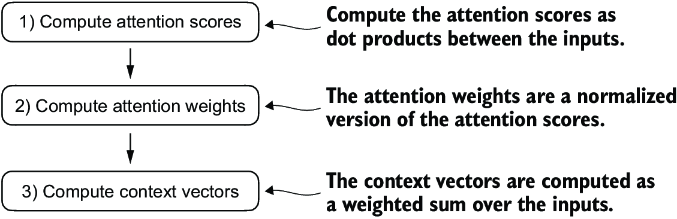

In [38]:
# to cal z_2

query = inputs[1]
# the context vector will the same shape as query 
context_vec_2 = torch.zeros(query.shape)

for i , x_i in enumerate(inputs):
    
  context_vec_2 += attn_score_softmax[i] * x_i 
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


#### 3.3.2 Computing attention weights for all input tokens

Now let’s extend this computation to calculate attention weights and context vectors for all inputs.(still we have only done with x2 and we have done with other x_1,3 and 4)

> attention weights matrix for all six inputs 

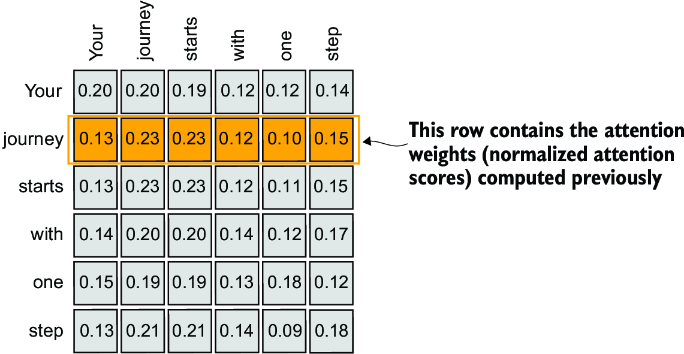


In [39]:
attn_matrix = torch.zeros(6,6)

for i, x_i in enumerate(inputs):
    for j , x_j in enumerate(inputs):
        attn_matrix[i,j] = torch.dot(x_i,x_j)
print(attn_matrix)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


>When computing the preceding attention score tensor, we used `for loops` in Python. However, for loops are generally slow, and we can achieve the same results using matrix multiplication:

In [40]:
attn_matrix_2 = inputs @ inputs.T
attn_matrix_2

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

In [44]:
atten_weights_matrix = torch.softmax(attn_matrix_2,dim=1) # normalising 
# dim = -1 cuase it is first from back 
atten_weights_matrix

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

In [49]:
sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
atten_weights_matrix.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

>we use these attention weights to compute all context vectors via matrix multiplication:

In [51]:
context_vector_fin = atten_weights_matrix @ inputs
context_vector_fin

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

#### 3.4 Implementing self-attention with trainable weights